In [1]:
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import cast

import gsw
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from scipy.optimize import brentq as find_root

In [3]:
CE01_ISSP_PATH = Path("../data/CE01ISSP_nitrate_binned_baseline_subtracted_2014-04-17_2023-09-17.nc")
CE02_SHSP_PATH = Path("../data/CE02SHSP_nitrate_binned_baseline_subtracted_2015-03-18_2024-07-14.nc")

ce01 = (
    xr.open_dataset(CE01_ISSP_PATH)
    .resample(time="1D")
    .mean()
    .interpolate_na(dim="depth", max_gap=3)
    .interpolate_na(dim="time", max_gap=np.timedelta64(3, "D"))
)
ce02 = (
    xr.open_dataset(CE02_SHSP_PATH)
    .resample(time="1D")
    .mean()
    .interpolate_na(dim="depth", max_gap=3)
    .interpolate_na(dim="time", max_gap=np.timedelta64(3, "D"))
)
ce01["spice"] = gsw.spiciness0(ce01["absolute_salinity"], ce01["conservative_temperature"])
ce02["spice"] = gsw.spiciness0(ce02["absolute_salinity"], ce02["conservative_temperature"])

In [4]:
ce01_monthly_mean = ce01.groupby("time.month").mean("time")
ce02_monthly_mean = ce02.groupby("time.month").mean("time")
ce01_monthly_median = ce01.groupby("time.month").median("time")
ce02_monthly_median = ce02.groupby("time.month").median("time")
ce01_monthly_max = ce01.groupby("time.month").max("time")
ce02_monthly_max = ce02.groupby("time.month").max("time")
ce01_monthly_min = ce01.groupby("time.month").min("time")
ce02_monthly_min = ce02.groupby("time.month").min("time")

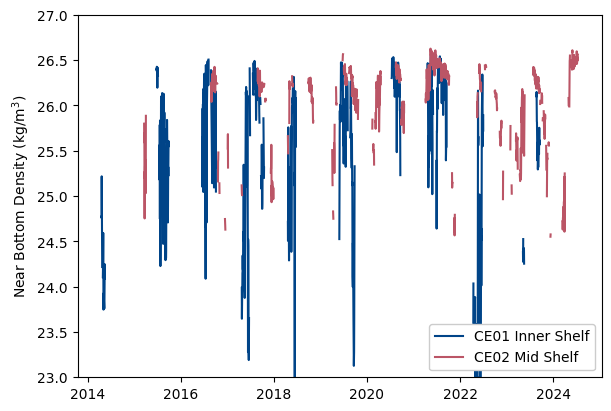

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")

ax.plot(ce01["time"], ce01.sel(depth=15)["sigma_theta"], label="CE01 Inner Shelf", c="#004488")
ax.plot(ce02["time"], ce02.sel(depth=60)["sigma_theta"], label="CE02 Mid Shelf", c="#BB5566")
ax.set_ylim(23, 27)
ax.set_ylabel("Near Bottom Density ($\\mathsf{kg/m^3}$)")
ax.legend(loc="lower right", framealpha=1)
plt.savefig("../misc/or_profiler_bottom_density_timeseries.png", dpi=300)

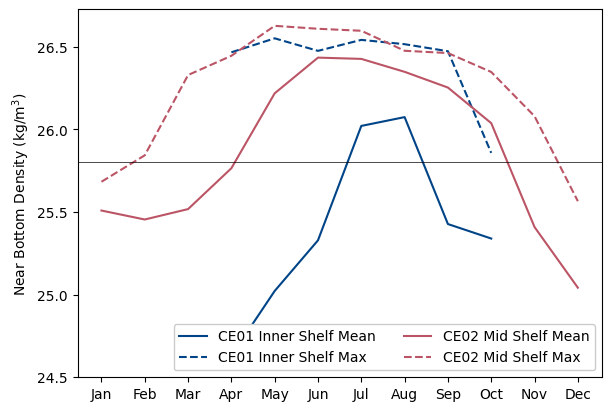

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")


ax.set_ylabel("Near Bottom Density ($\\mathsf{kg/m^3}$)")
ax.plot(
    ce01_monthly_mean["month"],
    ce01_monthly_mean.sel(depth=15)["sigma_theta"],
    label="CE01 Inner Shelf Mean",
    c="#004488",
)
ax.plot(
    ce01_monthly_max["month"],
    ce01_monthly_max.sel(depth=15)["sigma_theta"],
    label="CE01 Inner Shelf Max",
    linestyle="--",
    c="#004488",
)
ax.plot(
    ce02_monthly_mean["month"],
    ce02_monthly_mean.sel(depth=60)["sigma_theta"],
    label="CE02 Mid Shelf Mean",
    c="#BB5566",
)
ax.plot(
    ce02_monthly_max["month"],
    ce02_monthly_max.sel(depth=60)["sigma_theta"],
    label="CE02 Mid Shelf Max",
    linestyle="--",
    c="#BB5566",
)
ax.axhline(25.8, c="k", ls="-", lw=0.5)
ax.legend(loc="lower right", framealpha=1, ncols=2)
ax.set_yticks(np.arange(24.5, 27, 0.5))
ax.set_xticks(np.arange(1, 13))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: datetime(1900, int(x), 1).strftime("%b")))  # noqa: ARG005, DTZ001
plt.savefig("../misc/or_profiler_bottom_density_mean_monthly.png", dpi=300)

## Time series along 25.8 and 26.0

In [7]:
SIGMA_LAYER = [25.8, 26.0]

In [8]:
def calculate_mld(depth: np.ndarray, z: np.ndarray, sigma_0: np.ndarray, surface_sigma_0: float) -> float:
    """Calculate mixed layer depth for a single time step.

    Args:
        depth (np.ndarray): Array of depths at which to calculate the mixed layer depth.
        z (np.ndarray): Array of depths corresponding to sigma_0.
        sigma_0 (np.ndarray): Array of sigma_0 values.
        surface_sigma_0 (float): Surface sigma_0 value.

    Returns:
        float: Mixed layer depth.

    """
    mld = np.interp(depth, z, sigma_0, left=np.nan, right=np.nan) - surface_sigma_0
    return float(mld)


sigma_layer_depth = np.full((len(SIGMA_LAYER), ce02["time"].size), np.nan)

for i, sigma_0 in enumerate(
    ce02["sigma_theta"].isel(depth=slice(None)).to_numpy(),
):
    z = ce02["depth"].to_numpy()[~np.isnan(sigma_0)]
    sigma_0_filtered = sigma_0[~np.isnan(sigma_0)]
    for j, sigma_layer in enumerate(SIGMA_LAYER):
        try:
            sigma_layer_depth[j, i] = find_root(
                partial(
                    calculate_mld,
                    z=z,
                    sigma_0=sigma_0_filtered,
                    surface_sigma_0=sigma_layer,
                ),
                np.min(z),
                np.max(z),
            )
        except ValueError:
            sigma_layer_depth[j, i] = np.nan
sigma_layer_depth_da = xr.DataArray(
    sigma_layer_depth,
    coords={"sigma_layer": SIGMA_LAYER, "time": ce02["time"]},
    dims=["sigma_layer", "time"],
)

In [9]:
nitrate = ce02["salinity_corrected_nitrate"].interp(depth=sigma_layer_depth_da)
temp = ce02["conservative_temperature"].interp(depth=sigma_layer_depth_da)
sal = ce02["practical_salinity"].interp(depth=sigma_layer_depth_da)
spice = ce02["spice"].interp(depth=sigma_layer_depth_da)

c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:588: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x_loaded)
c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:589: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x_loaded)


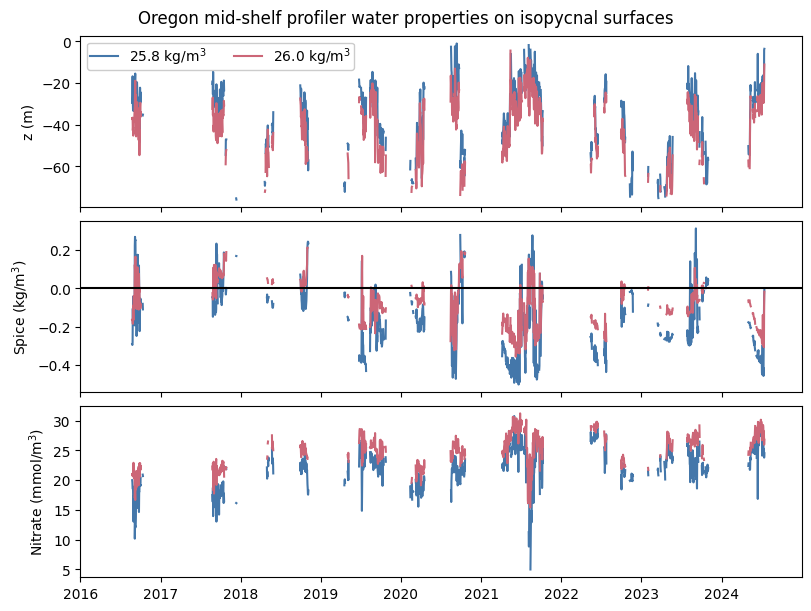

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), layout="constrained", sharex=True)
ax0 = cast("plt.Axes", axs[0])
ax1 = cast("plt.Axes", axs[1])
ax2 = cast("plt.Axes", axs[2])

ax0.set_xlim(np.datetime64("2016-01-01"), np.datetime64("2024-12-31"))  # ty: ignore[invalid-argument-type]

ax0.plot(ce02["time"], -sigma_layer_depth_da.sel(sigma_layer=25.8), label="25.8 $\\mathsf{kg/m^3}$", c="#4477AA")
ax0.plot(ce02["time"], -sigma_layer_depth_da.sel(sigma_layer=26.0), label="26.0 $\\mathsf{kg/m^3}$", c="#CC6677")
ax1.plot(ce02["time"], spice.sel(sigma_layer=25.8), c="#4477AA")
ax1.plot(ce02["time"], spice.sel(sigma_layer=26.0), c="#CC6677")
ax2.plot(ce02["time"], nitrate.sel(sigma_layer=25.8), c="#4477AA")
ax2.plot(ce02["time"], nitrate.sel(sigma_layer=26.0), c="#CC6677")

ax0.set_ylabel("z (m)")
ax1.set_ylabel("Spice ($\\mathsf{kg/m^3}$)")
ax2.set_ylabel("Nitrate ($\\mathsf{mmol/m^3}$)")

ax0.legend(framealpha=1, ncols=2, borderpad=0.2)
ax1.axhline(0, color="k", linestyle="-")


fig.suptitle("Oregon mid-shelf profiler water properties on isopycnal surfaces")

plt.savefig("../misc/or_profiler_isopycnal_properties_timeseries.png", dpi=300)